## Goal of Analysis:

### 1. determine each user's country based on the numeric IP address

### 2. Build a model to predict whether an activity is fraudulent or not

### 3. explain the model from a business or product side of view

In [24]:
import numpy as np
import pandas as pd

In [25]:
user = pd.read_csv('Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
user.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [26]:
user.dtypes

user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object

In [27]:
print('Variable', '   ', 'Count of unique value','  ', 'content')
for column in user.columns:
    uniques = user[column].unique()
    print('{0:20s} {1:4d}\t'.format(column, len(uniques)), uniques[:3])

Variable     Count of unique value    content
user_id              151112	 [ 22058 333320   1359]
signup_time          151112	 ['2015-02-24T22:55:49.000000000' '2015-06-07T20:39:50.000000000'
 '2015-01-01T18:52:44.000000000']
purchase_time        150679	 ['2015-04-18T02:47:11.000000000' '2015-06-08T01:38:54.000000000'
 '2015-01-01T18:52:45.000000000']
purchase_value        122	 [34 16 15]
device_id            137956	 ['QVPSPJUOCKZAR' 'EOGFQPIZPYXFZ' 'YSSKYOSJHPPLJ']
source                  3	 ['SEO' 'Ads' 'Direct']
browser                 5	 ['Chrome' 'Opera' 'Safari']
sex                     2	 ['M' 'F']
age                    58	 [39 53 41]
ip_address           143512	 [7.32758369e+08 3.50311388e+08 2.62147382e+09]
class                   2	 [0 1]


In [28]:
country = pd.read_csv('IpAddress_to_Country.csv')
country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [29]:
country.dtypes

lower_bound_ip_address    float64
upper_bound_ip_address      int64
country                    object
dtype: object

### Part 1: determine the country for each user

In [30]:
countries = []
for i in range(len(user)):
    ip_address = user.loc[i, 'ip_address']
    tmp = country[(country['lower_bound_ip_address'] <= ip_address) &
                  (country['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')

In [31]:
user['country'] = countries
user.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


### Part 2: Fraudulent activity detection

1. time difference between signup time and purchase time (too short period may indicate fraudulent activity)

2. whether there are many user id associated with one device id (could be fraud accounts)

3. whether there are many user id associated with one IP address

4. purchase week of the year, day of the week of the time variable

In [32]:
# time difference between signup time and purchase time
time_diff = user['purchase_time'] - user['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
user['time_diff'] = time_diff

In [33]:
# Check user number for unique devices
device_num = user[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'})
user = user.merge(device_num, how='left', on='device_id')

In [34]:
# Check user number for unique ip_address
ip_num = user[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns={'user_id': 'ip_num'})
user = user.merge(ip_num, how='left', on='ip_address')

In [35]:
# Signup day and week
user['signup_day'] = user['signup_time'].apply(lambda x: x.dayofweek)
user['signup_week'] = user['signup_time'].apply(lambda x: x.week)

# Purchase day and week
user['purchase_day'] = user['purchase_time'].apply(lambda x: x.dayofweek)
user['purchase_week'] = user['purchase_time'].apply(lambda x: x.week)

In [36]:
user.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


In [37]:
# Define features and target to be used
columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num', 'class']
data = user[columns]
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


we can see that for row 2, the class is 1, which means a fraudulent account, the device_number, ip_number, and signup time are all so different from others

#### next, I will use label encoder to tranform the data and make it easier for analysis

In [39]:
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Label encoder
le = LabelEncoder()
data_new = data[['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'age', 
                 'time_diff', 'device_num', 'ip_num']]
data_new['source'] = le.fit_transform(data['source'])
data_new['browser'] = le.fit_transform(data['browser'])
data_new['sex'] = le.fit_transform(data['sex'])
data_new['country'] = le.fit_transform(data['country'])

In [41]:
data_new

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,age,time_diff,device_num,ip_num,source,browser,sex,country
0,1,9,5,16,34,39,13882,1,1,2,0,1,84
1,6,23,0,24,16,53,17944,1,1,0,0,0,172
2,3,1,3,1,15,53,1,12,12,2,3,1,172
3,1,18,0,19,44,41,60085,1,1,2,4,1,115
4,1,30,2,37,39,45,41461,1,1,0,4,1,172
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,1,5,6,13,43,28,77233,2,1,2,0,1,172
151108,4,20,1,22,35,32,67270,1,1,2,4,1,119
151109,1,10,2,21,40,26,28816,1,1,2,2,0,84
151110,3,28,0,37,46,37,48519,2,1,2,0,1,172


In [40]:
data.rename(columns={'class':'is_fraud'},inplace=True)# 'class' is a reserved keyword
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,is_fraud
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


#### Next, I will build a model to detect the fraudulent activities, first I need to divide the dataset into training and testing

In [47]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X = data_new.loc[:,data_new.columns != 'is_fraud']
y = data.is_fraud

# split into training dataset and test dataset
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=42)
train_matrix = xgb.DMatrix(Xtrain,ytrain)
test_matrix = xgb.DMatrix(Xtest)

I am going to fit a random forest model, but first I need to find the best number of trees using cross validation

In [49]:
import warnings
warnings.filterwarnings('ignore')

params = {}
params['silent'] = 1
params['objective'] = 'binary:logistic'  # output probabilities
params['eval_metric'] = 'auc'
params["num_rounds"] = 300
params["early_stopping_rounds"] = 30
# params['min_child_weight'] = 2
params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

cv_results = xgb.cv(params,train_matrix,
                    num_boost_round = params["num_rounds"],
                    nfold = params.get('nfold',5),
                    metrics = params['eval_metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = True,
                    seed = seed)

[16:52:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "num_rounds", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:52:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "num_rounds", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:52:39] WARNING: /Users/run

In [51]:
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.842977,0.001660,0.842649,0.006622
1,0.843325,0.001879,0.842687,0.006659
2,0.843392,0.001862,0.842636,0.006685
3,0.843423,0.001847,0.842580,0.006675
4,0.843570,0.001831,0.842688,0.006614
5,0.843859,0.001923,0.842651,0.006637
6,0.844585,0.003047,0.842921,0.006288
7,0.844649,0.002991,0.842935,0.006250
8,0.847278,0.002990,0.843167,0.005321
9,0.848621,0.001425,0.843793,0.006561


In [50]:
n_best_trees = cv_results.shape[0]
n_best_trees

12

In [52]:
# retrain on the whole training dataset
watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees,watchlist)

[17:00:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "num_rounds", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.84293
[1]	train-auc:0.84257
[2]	train-auc:0.84272
[3]	train-auc:0.84282
[4]	train-auc:0.84320
[5]	train-auc:0.84328
[6]	train-auc:0.84354
[7]	train-auc:0.84397
[8]	train-auc:0.84402
[9]	train-auc:0.84416
[10]	train-auc:0.84419
[11]	train-auc:0.84809


In [56]:
### plot the ROC and choose a threshold
def plot_validation_roc():
    """
    we cannot plot ROC on either training set or test set, since both are biased
    so I split the training dataset again into training set and validation set
    retrain on training set and plot ROC on validation set and choose a proper cutoff value
    
    define a class to limit the naming group, avoid polluting the global naming space
    """
    Xtrain_only,Xvalid,ytrain_only,yvalid = train_test_split(Xtrain,ytrain,test_size=0.3,random_state=seed)
    onlytrain_matrix = xgb.DMatrix(Xtrain_only,ytrain_only)
    valid_matrix = xgb.DMatrix(Xvalid,yvalid)

    temp_gbt = xgb.train(params, onlytrain_matrix, n_best_trees,[(onlytrain_matrix,'train_only'),
                                                                 (valid_matrix,'validate')])
    yvalid_proba_pred = temp_gbt.predict(valid_matrix,ntree_limit=n_best_trees)

    fpr,tpr,thresholds = roc_curve(yvalid,yvalid_proba_pred)
    return pd.DataFrame({'FPR':fpr,'TPR':tpr,'Threshold':thresholds})

In [57]:
from sklearn.metrics import accuracy_score,classification_report,roc_curve    

roc = plot_validation_roc()

[17:01:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "num_rounds", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train_only-auc:0.84076	validate-auc:0.84708
[1]	train_only-auc:0.84095	validate-auc:0.84724
[2]	train_only-auc:0.84103	validate-auc:0.84720
[3]	train_only-auc:0.84087	validate-auc:0.84845
[4]	train_only-auc:0.84171	validate-auc:0.84703
[5]	train_only-auc:0.84179	validate-auc:0.84705
[6]	train_only-auc:0.84177	validate-auc:0.84702
[7]	train_only-auc:0.84186	validate-auc:0.84696
[8]	train_only-auc:0.84173	validate-auc:0.84687
[9]	train_only-auc:0.84193	validate-auc:0.84715
[10]	train_only-auc:0.84557	validat

Text(0, 0.5, 'TPR')

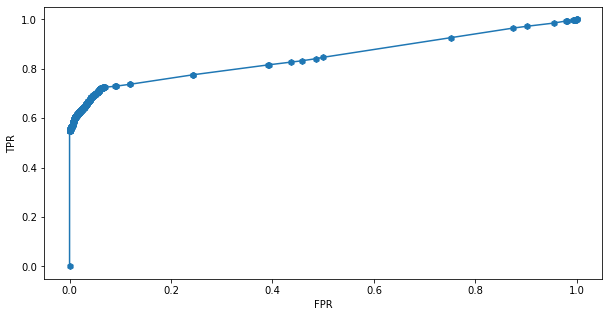

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(roc.FPR,roc.TPR,marker='h')
plt.xlabel("FPR")
plt.ylabel("TPR")

In [59]:
roc.loc[ (roc.TPR >= 0.78) & (roc.TPR <=0.83),:]

,FPR,TPR,Threshold
591,0.390869,0.815580,0.169269
592,0.393363,0.816170,0.169256
593,0.437162,0.827088,0.169253


In [ ]:
'''
Normally the "Fraud Detection Model" is used in a pre-screening step, 

the result of the model will be further investigated by expert later, 

so

if 'Not Fraud' is classified as 'Fraud', human expert can still have method to fix the problem
but if 'Fraud' is classified as 'Not Fraud', the company will lose money directly. 

so in this case, "false negative" cost much higher, so we should choose a relatively smaller threshold.
'''

### Part 3: Explain the features to business department

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

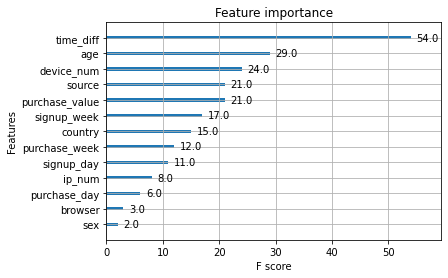

In [61]:
# first plot the feature importance from GBM
xgb.plot_importance(gbt)

Clearly, the most important feature is time difference, which is the time interval after sign up

we will next fit a random forest model to see it

In [86]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
clf = clf.fit(X, y)

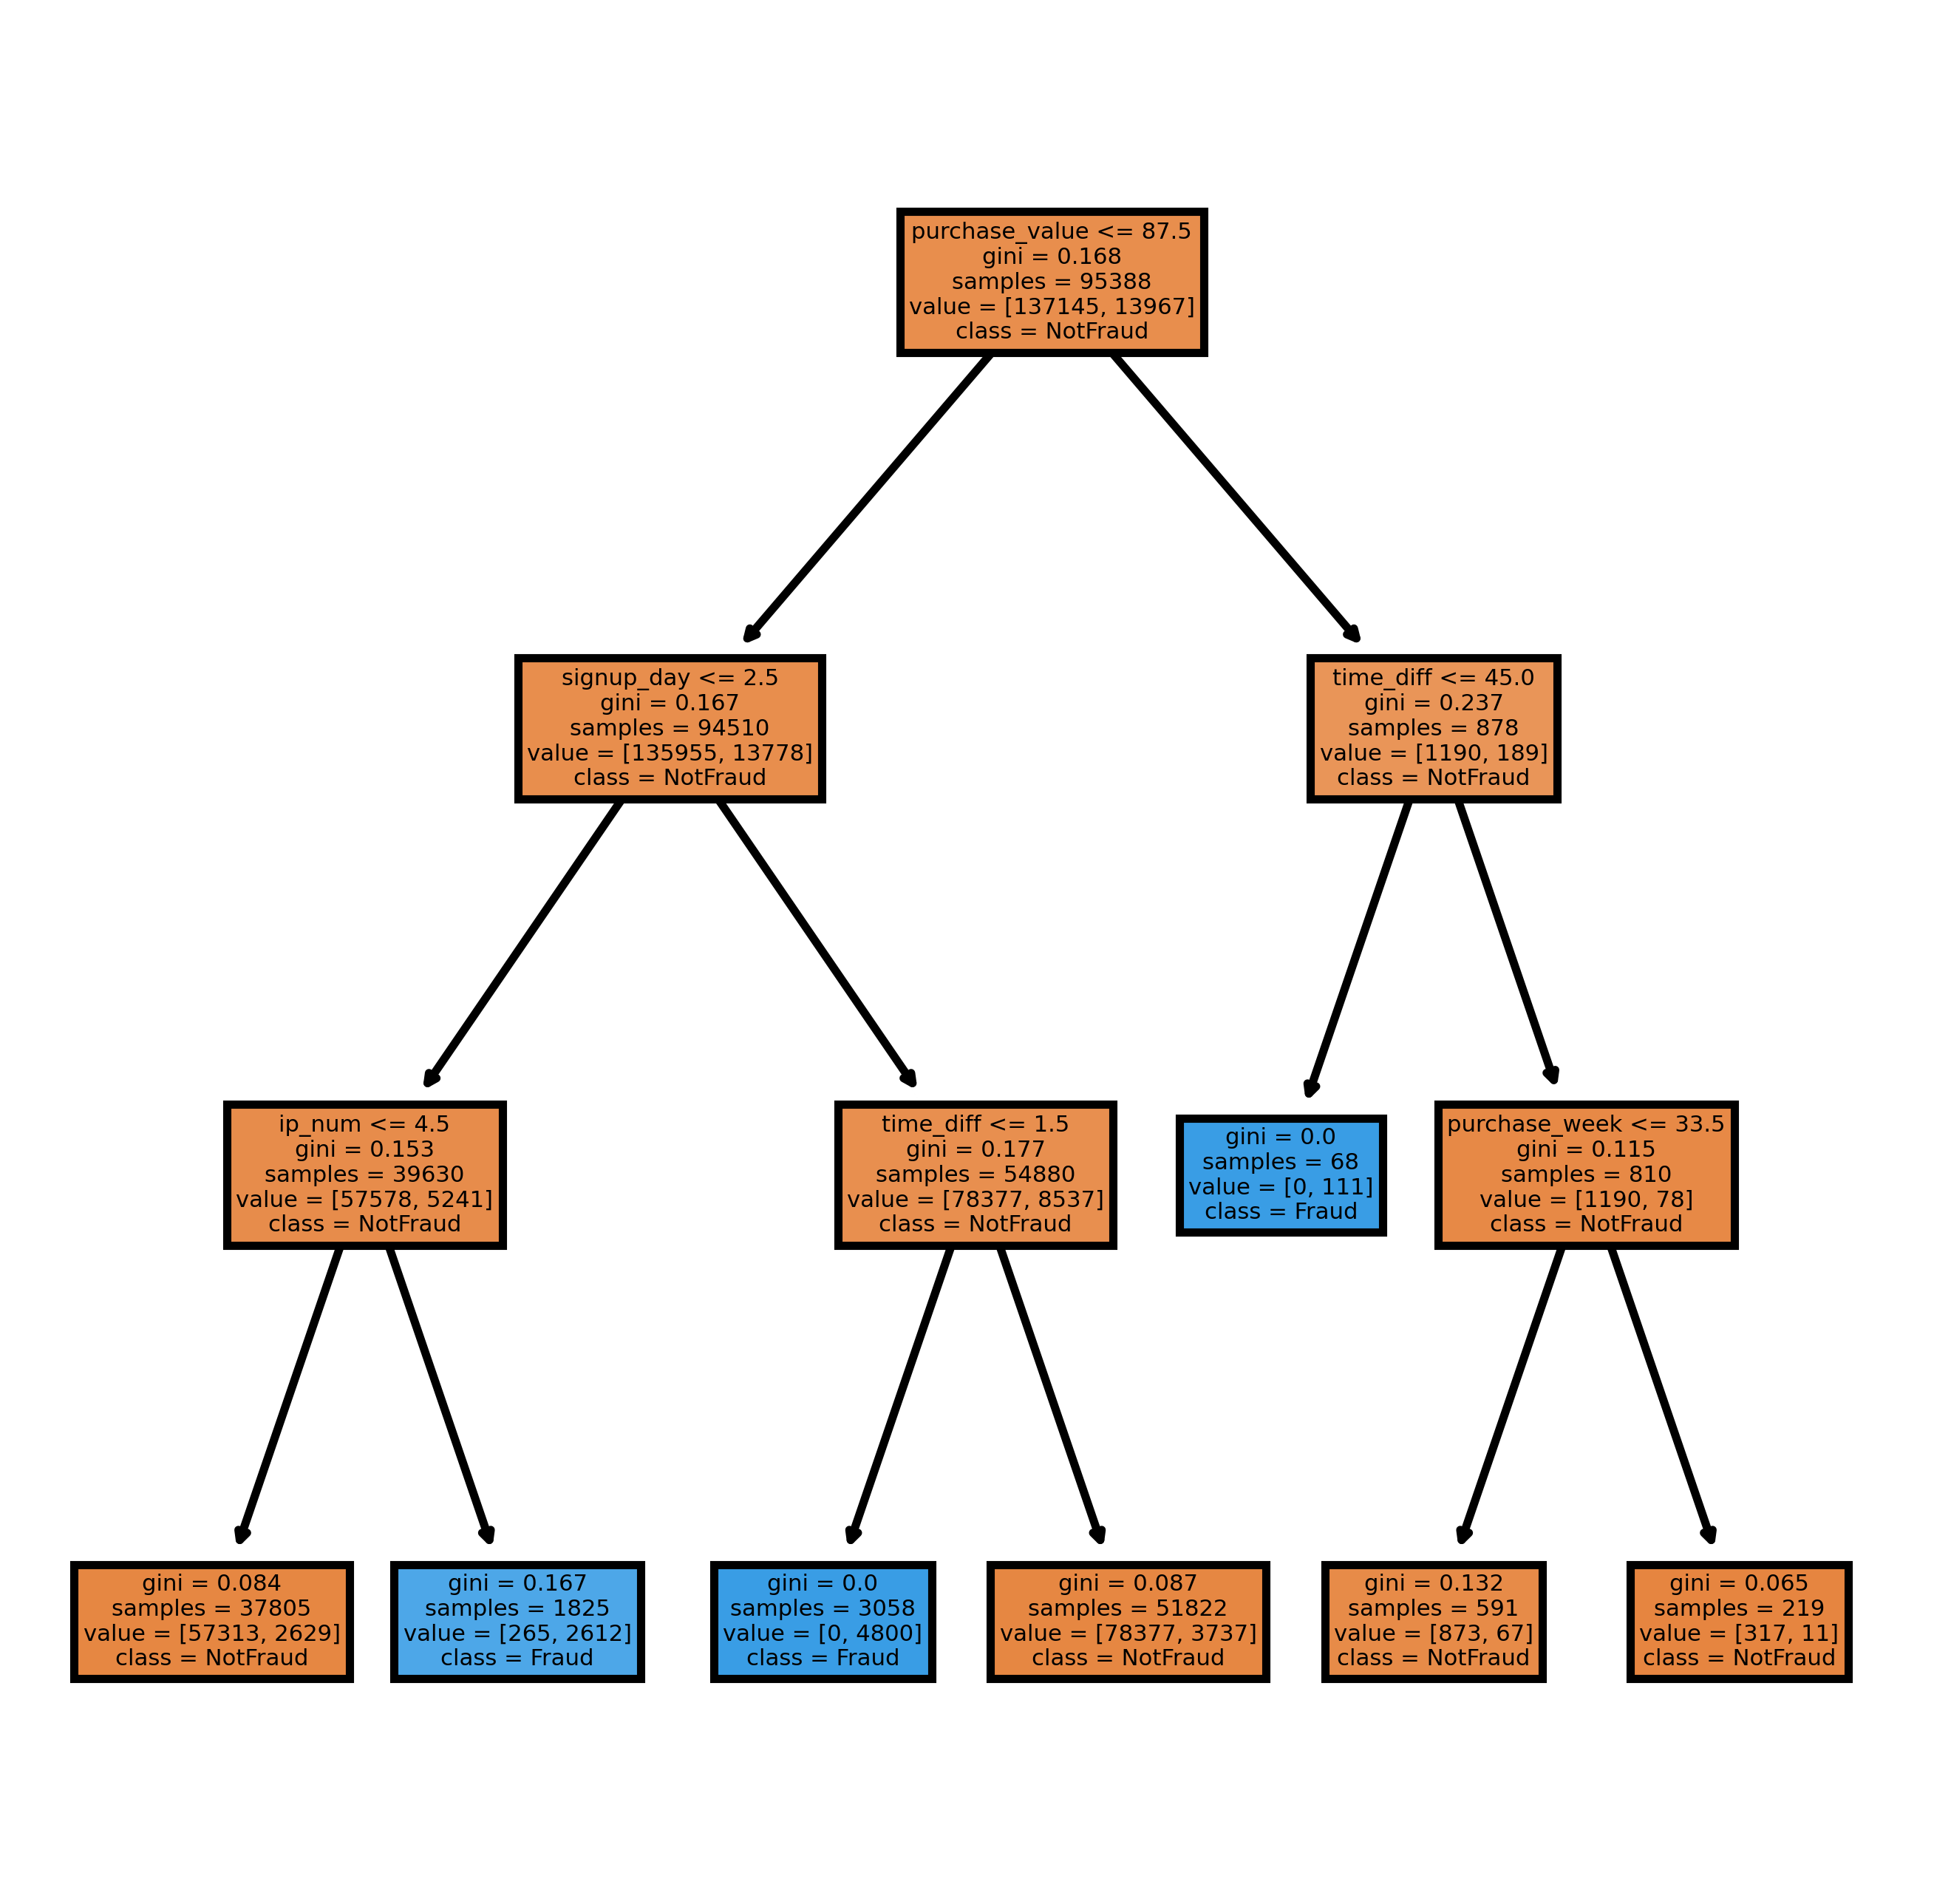

In [88]:
from sklearn import tree

fn=list(X.columns)
cn=['NotFraud', 'Fraud']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(clf.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);

From the random forest graph, we can see that:

if the time difference <45 seconds, it is likely to be a fraud

or, if the signup day <2.5 days and time difference <1.5 seconds, it is also likely to be a fraud